# Distinguish Your Own Digits (DYOD)

> How do you create your own classifer neural network from scratch? 

- author: Sakthisree

Hola!

As part of the Univ.ai KTF-1 course, I created this solution for one of the project questions. 

### Write a classifier that distinguishes the number 8 & number 3.

Gee. This might seem like a really simple question as first. 

>"Well, let's use scikit learn and all the other libraries we have and create a classifier in 3 lines."

But no. Let's use the Kudzu library where all the implementation for running a nerual network is written from scratch. 

Credits to Rahul (& of course, Joe Grus) for wonderfully showing how simple a neural network can be coded. 

Throughout this project, I make use of the Kudzu libray to run the models. 

Towards the end, you can also see a visualization of how the computer "splits" 3 & 8. 

Some of the things I have altered in the Kudzu library:

1. Added extra functions in the Callbacks call
2. Added tqdm for visualizing progress
3. Added softmax activation and softmax prime function. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
!pip install mnist

## Preparing the Data

> "What is MNIST anyway?"

The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems.

It was created by "re-mixing" the samples from NIST's original datasets.

The creators felt that since NIST's training dataset was taken from American Census Bureau employees, while the testing dataset was taken from American high school students, it was not well-suited for machine learning experiments.

Furthermore, the black and white images from NIST were normalized to fit into a 28x28 pixel bounding box and anti-aliased, which introduced grayscale levels.

The MNIST database contains 60,000 training images and 10,000 testing images.

Half of the training set and half of the test set were taken from NIST's training dataset, while the other half of the training set and the other half of the test set were taken from NIST's testing dataset

Source: Wikipedia


In [4]:
import mnist

In [5]:
#Loading the train images and labels from mnist
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
#Loading the test images and labels from mnist
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

Let's take a look at how this data looks like.

2


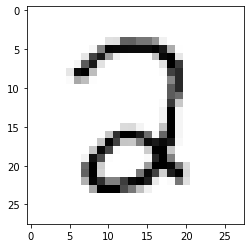

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

Now in order to create our classifier, we must filter our 3s and 8s from the lot. 

In [10]:
#filtering the 3 and 8 data - splitting it into test and train
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

In [11]:
#just storing all my 3 data in one variable for later use
data_3 = train_images[np.where(train_labels == 3)]
data_3 = data_3/255.
data_3 = data_3.reshape(data_3.shape[0], -1)
data_3.shape

(6131, 784)

In [12]:
#just storing all my 8 data in one variable for later use
data_8 = train_images[np.where(train_labels == 8)]
data_8 = data_8/255.
data_8 = data_8.reshape(data_8.shape[0], -1)
data_8.shape

(5851, 784)

We normalize the pizel values in the 0 to 1 range

In [13]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [14]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [15]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [16]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [17]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_train.shape, y_test.shape 

((11982, 1), (1984, 1))

### 1. I use the following configuration (or similar) to set up the model for training.

```pythom
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 200
config.bs = 50
```

Now construct a model which has the following layers

1. A first affine layer which has 784 inputs and does 100 affine transforms. These are followed by a `Relu`
2. A second affine layer which has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a `Relu`
3. A third affine layer which has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
4. A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.

In [18]:
from kudzu.model import Model
from kudzu.layer import Affine, Sigmoid, Relu
from kudzu.loss import BCE
from kudzu.optim import GD
from kudzu.data import Data, Dataloader, Sampler
from kudzu.train import Learner
from kudzu.callbacks import AccCallback

In [19]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 200
config.bs = 50

In [20]:
train_data = Data(X_train, y_train)
loss = BCE()
opt = GD(config.lr)
sampler = Sampler(train_data, config.bs, shuffle=True)
train_dl = Dataloader(train_data, sampler)

In [21]:
layers = [Affine("first", 784, 100), Relu("relu"), Affine("second", 100, 100), Relu("relu"), Affine("third", 100, 2), Affine("output", 2, 1), Sigmoid("sigmoid")]
model = Model(layers)

### 2. Create a callback class

I further added code to the  AccCallback class to add in the following functionalities. 

1. Initialized it to have accuracy arrays 

```python
        self.accuracies = []
        self.test_accuracies = []
```
2. Then at the end of each epoch, calculated the probabilities and hence predictions on both the training set and the test set. Printed these out once per epoch. 

3. Acumulated these in the above array. This will require me to keep track of all 4 training and test sets. 

4. I edited the `Learner` for this or pass these sets in some kind of data object to the callback.

5. I also added tqdm functionality in the AccCallback class in order to visually see the batch running progress per epoch.

In [22]:
learner = Learner(loss, model, opt, config.num_epochs)
acc = AccCallback(learner, config.bs)
learner.set_callbacks([acc])

### 3. Train the model

In [23]:
learner.train_loop(train_dl, X_test, y_test)

Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 289.36it/s]


Epoch: 0     Loss: 0.63479     Training Acc: 0.69095     Validation Acc: 0.83367


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 285.78it/s]


Epoch: 1     Loss: 0.51553     Training Acc: 0.86321     Validation Acc: 0.86215


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 273.81it/s]


Epoch: 2     Loss: 0.41442     Training Acc: 0.89092     Validation Acc: 0.87618


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 269.70it/s]


Epoch: 3     Loss: 0.33761     Training Acc: 0.90694     Validation Acc: 0.88596


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 283.72it/s]


Epoch: 4     Loss: 0.28335     Training Acc: 0.9198     Validation Acc: 0.89355


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 264.08it/s]


Epoch: 5     Loss: 0.24552     Training Acc: 0.92706     Validation Acc: 0.90113


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 290.50it/s]


Epoch: 6     Loss: 0.21825     Training Acc: 0.9329     Validation Acc: 0.90719


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 271.30it/s]


Epoch: 7     Loss: 0.19798     Training Acc: 0.93908     Validation Acc: 0.91249


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 274.07it/s]


Epoch: 8     Loss: 0.1826     Training Acc: 0.94291     Validation Acc: 0.91689


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 278.76it/s]


Epoch: 9     Loss: 0.17065     Training Acc: 0.94492     Validation Acc: 0.92067


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 276.84it/s]


Epoch: 10     Loss: 0.16119     Training Acc: 0.94809     Validation Acc: 0.92394


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 286.97it/s]


Epoch: 11     Loss: 0.15349     Training Acc: 0.95001     Validation Acc: 0.92679


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 285.04it/s]


Epoch: 12     Loss: 0.14716     Training Acc: 0.95209     Validation Acc: 0.92944


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 286.15it/s]


Epoch: 13     Loss: 0.14184     Training Acc: 0.95385     Validation Acc: 0.93174


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 285.69it/s]


Epoch: 14     Loss: 0.13741     Training Acc: 0.95527     Validation Acc: 0.9338


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 280.17it/s]


Epoch: 15     Loss: 0.13346     Training Acc: 0.95669     Validation Acc: 0.93558


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 278.77it/s]


Epoch: 16     Loss: 0.1302     Training Acc: 0.95835     Validation Acc: 0.93714


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 279.13it/s]


Epoch: 17     Loss: 0.12709     Training Acc: 0.95869     Validation Acc: 0.93859


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 287.99it/s]


Epoch: 18     Loss: 0.12449     Training Acc: 0.95969     Validation Acc: 0.93991


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 280.50it/s]


Epoch: 19     Loss: 0.12207     Training Acc: 0.96044     Validation Acc: 0.94105


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 287.30it/s]


Epoch: 20     Loss: 0.11989     Training Acc: 0.96094     Validation Acc: 0.94211


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 288.04it/s]


Epoch: 21     Loss: 0.11784     Training Acc: 0.96261     Validation Acc: 0.94314


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 289.68it/s]


Epoch: 22     Loss: 0.11607     Training Acc: 0.96294     Validation Acc: 0.94407


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 288.73it/s]


Epoch: 23     Loss: 0.11435     Training Acc: 0.96311     Validation Acc: 0.94498


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 289.21it/s]


Epoch: 24     Loss: 0.11279     Training Acc: 0.96345     Validation Acc: 0.94583


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 289.12it/s]


Epoch: 25     Loss: 0.11128     Training Acc: 0.9642     Validation Acc: 0.94663


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 288.90it/s]


Epoch: 26     Loss: 0.1099     Training Acc: 0.96453     Validation Acc: 0.94741


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 286.85it/s]


Epoch: 27     Loss: 0.10846     Training Acc: 0.96553     Validation Acc: 0.94819


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 284.88it/s]


Epoch: 28     Loss: 0.10738     Training Acc: 0.96587     Validation Acc: 0.94892


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 289.42it/s]


Epoch: 29     Loss: 0.10617     Training Acc: 0.96645     Validation Acc: 0.94961


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 287.49it/s]


Epoch: 30     Loss: 0.10508     Training Acc: 0.96737     Validation Acc: 0.9503


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 284.25it/s]


Epoch: 31     Loss: 0.10392     Training Acc: 0.96745     Validation Acc: 0.95092


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 283.11it/s]


Epoch: 32     Loss: 0.103     Training Acc: 0.96787     Validation Acc: 0.95154


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 271.02it/s]


Epoch: 33     Loss: 0.10193     Training Acc: 0.9682     Validation Acc: 0.95209


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 282.75it/s]


Epoch: 34     Loss: 0.10104     Training Acc: 0.96862     Validation Acc: 0.95264


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 288.07it/s]


Epoch: 35     Loss: 0.10013     Training Acc: 0.96862     Validation Acc: 0.95318


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 286.92it/s]


Epoch: 36     Loss: 0.09928     Training Acc: 0.96904     Validation Acc: 0.95368


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 287.24it/s]


Epoch: 37     Loss: 0.09842     Training Acc: 0.96954     Validation Acc: 0.95412


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 289.91it/s]


Epoch: 38     Loss: 0.0976     Training Acc: 0.96954     Validation Acc: 0.95461


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 289.94it/s]


Epoch: 39     Loss: 0.09679     Training Acc: 0.97021     Validation Acc: 0.95508


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 290.15it/s]


Epoch: 40     Loss: 0.09599     Training Acc: 0.97087     Validation Acc: 0.95551


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 287.13it/s]


Epoch: 41     Loss: 0.0952     Training Acc: 0.97054     Validation Acc: 0.95595


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 291.49it/s]


Epoch: 42     Loss: 0.09441     Training Acc: 0.97046     Validation Acc: 0.95634


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 288.12it/s]


Epoch: 43     Loss: 0.09378     Training Acc: 0.97129     Validation Acc: 0.95673


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 286.76it/s]


Epoch: 44     Loss: 0.09302     Training Acc: 0.97112     Validation Acc: 0.95711


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 287.12it/s]


Epoch: 45     Loss: 0.09228     Training Acc: 0.97129     Validation Acc: 0.95748


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 287.69it/s]


Epoch: 46     Loss: 0.09161     Training Acc: 0.97146     Validation Acc: 0.95782


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 288.18it/s]


Epoch: 47     Loss: 0.09097     Training Acc: 0.97179     Validation Acc: 0.95815


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 283.52it/s]


Epoch: 48     Loss: 0.09024     Training Acc: 0.97204     Validation Acc: 0.95849


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 282.37it/s]


Epoch: 49     Loss: 0.08961     Training Acc: 0.97179     Validation Acc: 0.95882


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 278.12it/s]


Epoch: 50     Loss: 0.08899     Training Acc: 0.97238     Validation Acc: 0.95913


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 278.87it/s]


Epoch: 51     Loss: 0.08833     Training Acc: 0.97254     Validation Acc: 0.95942


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 281.63it/s]


Epoch: 52     Loss: 0.08776     Training Acc: 0.97263     Validation Acc: 0.9597


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 279.82it/s]


Epoch: 53     Loss: 0.08711     Training Acc: 0.97304     Validation Acc: 0.95998


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 283.98it/s]


Epoch: 54     Loss: 0.08643     Training Acc: 0.97271     Validation Acc: 0.96025


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 277.87it/s]


Epoch: 55     Loss: 0.08588     Training Acc: 0.97296     Validation Acc: 0.96052


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 285.16it/s]


Epoch: 56     Loss: 0.08531     Training Acc: 0.97354     Validation Acc: 0.96079


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 287.93it/s]


Epoch: 57     Loss: 0.08462     Training Acc: 0.97371     Validation Acc: 0.96102


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 288.08it/s]


Epoch: 58     Loss: 0.08417     Training Acc: 0.97379     Validation Acc: 0.96127


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 288.11it/s]


Epoch: 59     Loss: 0.08354     Training Acc: 0.97379     Validation Acc: 0.96152


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 281.43it/s]


Epoch: 60     Loss: 0.08281     Training Acc: 0.97388     Validation Acc: 0.96176


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 274.89it/s]


Epoch: 61     Loss: 0.08242     Training Acc: 0.97413     Validation Acc: 0.96199


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 283.65it/s]


Epoch: 62     Loss: 0.08179     Training Acc: 0.97421     Validation Acc: 0.96218


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 282.10it/s]


Epoch: 63     Loss: 0.08124     Training Acc: 0.9748     Validation Acc: 0.96238


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 286.06it/s]


Epoch: 64     Loss: 0.08072     Training Acc: 0.97446     Validation Acc: 0.96259


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 283.40it/s]


Epoch: 65     Loss: 0.08008     Training Acc: 0.9753     Validation Acc: 0.96278


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 285.46it/s]


Epoch: 66     Loss: 0.07951     Training Acc: 0.97471     Validation Acc: 0.96299


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 281.84it/s]


Epoch: 67     Loss: 0.07905     Training Acc: 0.97555     Validation Acc: 0.96317


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 273.54it/s]


Epoch: 68     Loss: 0.07848     Training Acc: 0.97546     Validation Acc: 0.96335


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 271.13it/s]


Epoch: 69     Loss: 0.07798     Training Acc: 0.9758     Validation Acc: 0.96353


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 277.92it/s]


Epoch: 70     Loss: 0.07743     Training Acc: 0.97613     Validation Acc: 0.96372


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 286.60it/s]


Epoch: 71     Loss: 0.07692     Training Acc: 0.97621     Validation Acc: 0.96388


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 289.67it/s]


Epoch: 72     Loss: 0.0764     Training Acc: 0.97646     Validation Acc: 0.96405


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 283.70it/s]


Epoch: 73     Loss: 0.07585     Training Acc: 0.97705     Validation Acc: 0.96422


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 285.25it/s]


Epoch: 74     Loss: 0.0753     Training Acc: 0.97688     Validation Acc: 0.96437


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 269.31it/s]


Epoch: 75     Loss: 0.0748     Training Acc: 0.97763     Validation Acc: 0.96453


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 286.06it/s]


Epoch: 76     Loss: 0.07435     Training Acc: 0.9778     Validation Acc: 0.96468


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 271.55it/s]


Epoch: 77     Loss: 0.0738     Training Acc: 0.97713     Validation Acc: 0.96483


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 283.61it/s]


Epoch: 78     Loss: 0.07332     Training Acc: 0.97788     Validation Acc: 0.96499


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 289.22it/s]


Epoch: 79     Loss: 0.07277     Training Acc: 0.97813     Validation Acc: 0.96514


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 284.09it/s]


Epoch: 80     Loss: 0.0723     Training Acc: 0.97813     Validation Acc: 0.96528


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 281.73it/s]


Epoch: 81     Loss: 0.07181     Training Acc: 0.97838     Validation Acc: 0.96542


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 285.30it/s]


Epoch: 82     Loss: 0.07125     Training Acc: 0.97838     Validation Acc: 0.96555


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 284.24it/s]


Epoch: 83     Loss: 0.07083     Training Acc: 0.97872     Validation Acc: 0.96568


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 287.29it/s]


Epoch: 84     Loss: 0.07036     Training Acc: 0.97905     Validation Acc: 0.9658


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 286.53it/s]


Epoch: 85     Loss: 0.06984     Training Acc: 0.97922     Validation Acc: 0.96593


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 283.34it/s]


Epoch: 86     Loss: 0.0694     Training Acc: 0.97922     Validation Acc: 0.96606


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 286.93it/s]


Epoch: 87     Loss: 0.06884     Training Acc: 0.97972     Validation Acc: 0.96619


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 285.95it/s]


Epoch: 88     Loss: 0.0684     Training Acc: 0.9798     Validation Acc: 0.9663


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 279.23it/s]


Epoch: 89     Loss: 0.06793     Training Acc: 0.98022     Validation Acc: 0.96641


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 283.56it/s]


Epoch: 90     Loss: 0.06749     Training Acc: 0.98005     Validation Acc: 0.96652


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 277.04it/s]


Epoch: 91     Loss: 0.06701     Training Acc: 0.98014     Validation Acc: 0.96664


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 281.18it/s]


Epoch: 92     Loss: 0.06655     Training Acc: 0.98055     Validation Acc: 0.96676


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 285.67it/s]


Epoch: 93     Loss: 0.0661     Training Acc: 0.98072     Validation Acc: 0.96687


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 276.56it/s]


Epoch: 94     Loss: 0.06562     Training Acc: 0.9803     Validation Acc: 0.96697


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 286.64it/s]


Epoch: 95     Loss: 0.0651     Training Acc: 0.98097     Validation Acc: 0.96707


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 281.31it/s]


Epoch: 96     Loss: 0.06475     Training Acc: 0.98122     Validation Acc: 0.96718


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 285.34it/s]


Epoch: 97     Loss: 0.06423     Training Acc: 0.98147     Validation Acc: 0.96728


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 291.73it/s]


Epoch: 98     Loss: 0.06377     Training Acc: 0.98189     Validation Acc: 0.96738


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 283.96it/s]


Epoch: 99     Loss: 0.06332     Training Acc: 0.98197     Validation Acc: 0.96748


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 278.32it/s]


Epoch: 100     Loss: 0.06289     Training Acc: 0.98164     Validation Acc: 0.96759


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 280.30it/s]


Epoch: 101     Loss: 0.06241     Training Acc: 0.98222     Validation Acc: 0.96769


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 283.20it/s]


Epoch: 102     Loss: 0.062     Training Acc: 0.98256     Validation Acc: 0.9678


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 285.83it/s]


Epoch: 103     Loss: 0.06155     Training Acc: 0.98264     Validation Acc: 0.96789


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 286.00it/s]


Epoch: 104     Loss: 0.06109     Training Acc: 0.98272     Validation Acc: 0.96799


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 284.34it/s]


Epoch: 105     Loss: 0.06069     Training Acc: 0.98322     Validation Acc: 0.96808


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 289.07it/s]


Epoch: 106     Loss: 0.06025     Training Acc: 0.98331     Validation Acc: 0.96818


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 288.31it/s]


Epoch: 107     Loss: 0.05976     Training Acc: 0.98331     Validation Acc: 0.96827


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 281.14it/s]


Epoch: 108     Loss: 0.05937     Training Acc: 0.98348     Validation Acc: 0.96837


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 276.89it/s]


Epoch: 109     Loss: 0.05895     Training Acc: 0.98389     Validation Acc: 0.96846


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 269.85it/s]


Epoch: 110     Loss: 0.0585     Training Acc: 0.98389     Validation Acc: 0.96855


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 247.91it/s]


Epoch: 111     Loss: 0.05811     Training Acc: 0.98423     Validation Acc: 0.96863


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 278.56it/s]


Epoch: 112     Loss: 0.05767     Training Acc: 0.98456     Validation Acc: 0.96872


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 249.20it/s]


Epoch: 113     Loss: 0.05723     Training Acc: 0.98423     Validation Acc: 0.9688


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 269.75it/s]


Epoch: 114     Loss: 0.05685     Training Acc: 0.98439     Validation Acc: 0.96888


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 276.50it/s]


Epoch: 115     Loss: 0.05638     Training Acc: 0.98464     Validation Acc: 0.96896


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 268.91it/s]


Epoch: 116     Loss: 0.05601     Training Acc: 0.98464     Validation Acc: 0.96904


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 268.12it/s]


Epoch: 117     Loss: 0.05559     Training Acc: 0.98464     Validation Acc: 0.96913


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 271.14it/s]


Epoch: 118     Loss: 0.05517     Training Acc: 0.98489     Validation Acc: 0.96921


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 281.77it/s]


Epoch: 119     Loss: 0.05478     Training Acc: 0.98489     Validation Acc: 0.96929


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 283.46it/s]


Epoch: 120     Loss: 0.0544     Training Acc: 0.98489     Validation Acc: 0.96936


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 266.51it/s]


Epoch: 121     Loss: 0.05401     Training Acc: 0.98523     Validation Acc: 0.96943


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 277.12it/s]


Epoch: 122     Loss: 0.05363     Training Acc: 0.98523     Validation Acc: 0.9695


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 284.16it/s]


Epoch: 123     Loss: 0.05321     Training Acc: 0.98531     Validation Acc: 0.96958


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 286.71it/s]


Epoch: 124     Loss: 0.05284     Training Acc: 0.98531     Validation Acc: 0.96965


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 286.13it/s]


Epoch: 125     Loss: 0.05246     Training Acc: 0.98548     Validation Acc: 0.96972


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 282.78it/s]


Epoch: 126     Loss: 0.05203     Training Acc: 0.98556     Validation Acc: 0.9698


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 270.73it/s]


Epoch: 127     Loss: 0.05167     Training Acc: 0.9859     Validation Acc: 0.96987


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 263.29it/s]


Epoch: 128     Loss: 0.05132     Training Acc: 0.98573     Validation Acc: 0.96994


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 263.16it/s]


Epoch: 129     Loss: 0.05092     Training Acc: 0.98573     Validation Acc: 0.97001


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 280.57it/s]


Epoch: 130     Loss: 0.05057     Training Acc: 0.98606     Validation Acc: 0.97009


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 276.77it/s]


Epoch: 131     Loss: 0.05023     Training Acc: 0.98598     Validation Acc: 0.97016


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 280.43it/s]


Epoch: 132     Loss: 0.04983     Training Acc: 0.98623     Validation Acc: 0.97023


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 284.36it/s]


Epoch: 133     Loss: 0.04948     Training Acc: 0.98606     Validation Acc: 0.9703


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 288.05it/s]


Epoch: 134     Loss: 0.04895     Training Acc: 0.98623     Validation Acc: 0.97036


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 285.89it/s]


Epoch: 135     Loss: 0.0488     Training Acc: 0.98631     Validation Acc: 0.97043


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 281.49it/s]


Epoch: 136     Loss: 0.04839     Training Acc: 0.98648     Validation Acc: 0.97049


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 272.67it/s]


Epoch: 137     Loss: 0.04806     Training Acc: 0.98656     Validation Acc: 0.97056


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 273.03it/s]


Epoch: 138     Loss: 0.04767     Training Acc: 0.98673     Validation Acc: 0.97063


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 271.45it/s]


Epoch: 139     Loss: 0.04727     Training Acc: 0.98698     Validation Acc: 0.9707


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 285.55it/s]


Epoch: 140     Loss: 0.04702     Training Acc: 0.9869     Validation Acc: 0.97077


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 284.09it/s]


Epoch: 141     Loss: 0.04667     Training Acc: 0.98706     Validation Acc: 0.97083


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 277.43it/s]


Epoch: 142     Loss: 0.04635     Training Acc: 0.98723     Validation Acc: 0.9709


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 284.98it/s]


Epoch: 143     Loss: 0.04602     Training Acc: 0.9874     Validation Acc: 0.97097


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 282.82it/s]


Epoch: 144     Loss: 0.04569     Training Acc: 0.9874     Validation Acc: 0.97104


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 278.99it/s]


Epoch: 145     Loss: 0.04533     Training Acc: 0.9874     Validation Acc: 0.97111


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 270.74it/s]


Epoch: 146     Loss: 0.04498     Training Acc: 0.9879     Validation Acc: 0.97118


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 267.87it/s]


Epoch: 147     Loss: 0.04458     Training Acc: 0.98765     Validation Acc: 0.97125


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 277.17it/s]


Epoch: 148     Loss: 0.04433     Training Acc: 0.9879     Validation Acc: 0.97131


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 264.21it/s]


Epoch: 149     Loss: 0.04402     Training Acc: 0.9879     Validation Acc: 0.97137


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 251.70it/s]


Epoch: 150     Loss: 0.04369     Training Acc: 0.98798     Validation Acc: 0.97144


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 266.68it/s]


Epoch: 151     Loss: 0.04338     Training Acc: 0.98807     Validation Acc: 0.97151


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 254.45it/s]


Epoch: 152     Loss: 0.04305     Training Acc: 0.98807     Validation Acc: 0.97157


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 277.63it/s]


Epoch: 153     Loss: 0.04273     Training Acc: 0.9884     Validation Acc: 0.97163


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 275.24it/s]


Epoch: 154     Loss: 0.04245     Training Acc: 0.9884     Validation Acc: 0.9717


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 267.55it/s]


Epoch: 155     Loss: 0.04207     Training Acc: 0.98848     Validation Acc: 0.97176


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 272.20it/s]


Epoch: 156     Loss: 0.04181     Training Acc: 0.98848     Validation Acc: 0.97182


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 270.54it/s]


Epoch: 157     Loss: 0.04149     Training Acc: 0.98857     Validation Acc: 0.97188


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 282.30it/s]


Epoch: 158     Loss: 0.04117     Training Acc: 0.98882     Validation Acc: 0.97194


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 286.42it/s]


Epoch: 159     Loss: 0.04085     Training Acc: 0.9889     Validation Acc: 0.972


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 283.74it/s]


Epoch: 160     Loss: 0.04054     Training Acc: 0.9894     Validation Acc: 0.97206


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 283.26it/s]


Epoch: 161     Loss: 0.04026     Training Acc: 0.98865     Validation Acc: 0.97212


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 281.39it/s]


Epoch: 162     Loss: 0.03994     Training Acc: 0.9889     Validation Acc: 0.97217


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 247.43it/s]


Epoch: 163     Loss: 0.03964     Training Acc: 0.98898     Validation Acc: 0.97223


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 255.59it/s]


Epoch: 164     Loss: 0.03939     Training Acc: 0.98898     Validation Acc: 0.97228


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 280.73it/s]


Epoch: 165     Loss: 0.03909     Training Acc: 0.98923     Validation Acc: 0.97234


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 252.88it/s]


Epoch: 166     Loss: 0.03881     Training Acc: 0.9894     Validation Acc: 0.9724


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 256.15it/s]


Epoch: 167     Loss: 0.03847     Training Acc: 0.98957     Validation Acc: 0.97246


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 268.83it/s]


Epoch: 168     Loss: 0.03825     Training Acc: 0.98948     Validation Acc: 0.97251


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 279.82it/s]


Epoch: 169     Loss: 0.03793     Training Acc: 0.98932     Validation Acc: 0.97256


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 284.84it/s]


Epoch: 170     Loss: 0.03764     Training Acc: 0.98948     Validation Acc: 0.97261


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 277.46it/s]


Epoch: 171     Loss: 0.03735     Training Acc: 0.98948     Validation Acc: 0.97267


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 242.04it/s]


Epoch: 172     Loss: 0.03712     Training Acc: 0.98982     Validation Acc: 0.97272


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 249.73it/s]


Epoch: 173     Loss: 0.03681     Training Acc: 0.98982     Validation Acc: 0.97278


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 281.86it/s]


Epoch: 174     Loss: 0.03648     Training Acc: 0.98982     Validation Acc: 0.97283


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 283.94it/s]


Epoch: 175     Loss: 0.03623     Training Acc: 0.98982     Validation Acc: 0.97289


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 282.61it/s]


Epoch: 176     Loss: 0.03604     Training Acc: 0.98998     Validation Acc: 0.97294


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 286.07it/s]


Epoch: 177     Loss: 0.03568     Training Acc: 0.98998     Validation Acc: 0.97299


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 281.28it/s]


Epoch: 178     Loss: 0.03543     Training Acc: 0.99015     Validation Acc: 0.97304


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 283.60it/s]


Epoch: 179     Loss: 0.03515     Training Acc: 0.99049     Validation Acc: 0.9731


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 287.04it/s]


Epoch: 180     Loss: 0.03498     Training Acc: 0.99032     Validation Acc: 0.97314


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 285.92it/s]


Epoch: 181     Loss: 0.03466     Training Acc: 0.9904     Validation Acc: 0.97319


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 285.92it/s]


Epoch: 182     Loss: 0.03441     Training Acc: 0.99057     Validation Acc: 0.97325


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 287.31it/s]


Epoch: 183     Loss: 0.03414     Training Acc: 0.99099     Validation Acc: 0.9733


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 285.10it/s]


Epoch: 184     Loss: 0.03392     Training Acc: 0.99082     Validation Acc: 0.97335


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 294.34it/s]


Epoch: 185     Loss: 0.03366     Training Acc: 0.99132     Validation Acc: 0.97341


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 279.57it/s]


Epoch: 186     Loss: 0.03338     Training Acc: 0.99115     Validation Acc: 0.97346


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 285.23it/s]


Epoch: 187     Loss: 0.03316     Training Acc: 0.99099     Validation Acc: 0.97352


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 284.12it/s]


Epoch: 188     Loss: 0.03292     Training Acc: 0.99124     Validation Acc: 0.97357


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 284.33it/s]


Epoch: 189     Loss: 0.03266     Training Acc: 0.9909     Validation Acc: 0.97363


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 263.52it/s]


Epoch: 190     Loss: 0.03237     Training Acc: 0.99132     Validation Acc: 0.97368


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 276.46it/s]


Epoch: 191     Loss: 0.03216     Training Acc: 0.99132     Validation Acc: 0.97374


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 259.59it/s]


Epoch: 192     Loss: 0.03192     Training Acc: 0.9914     Validation Acc: 0.9738


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 247.77it/s]


Epoch: 193     Loss: 0.0317     Training Acc: 0.99157     Validation Acc: 0.97385


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 256.13it/s]


Epoch: 194     Loss: 0.03142     Training Acc: 0.99182     Validation Acc: 0.97391


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 277.72it/s]


Epoch: 195     Loss: 0.03118     Training Acc: 0.9919     Validation Acc: 0.97396


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 286.41it/s]


Epoch: 196     Loss: 0.03095     Training Acc: 0.99182     Validation Acc: 0.97402


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 279.64it/s]


Epoch: 197     Loss: 0.03071     Training Acc: 0.99174     Validation Acc: 0.97407


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 279.57it/s]


Epoch: 198     Loss: 0.03051     Training Acc: 0.9919     Validation Acc: 0.97413


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 266.92it/s]


Epoch: 199     Loss: 0.03022     Training Acc: 0.99199     Validation Acc: 0.97418


0.004273291140054447

Now that the training has completed, let's take a look at how our model performed.

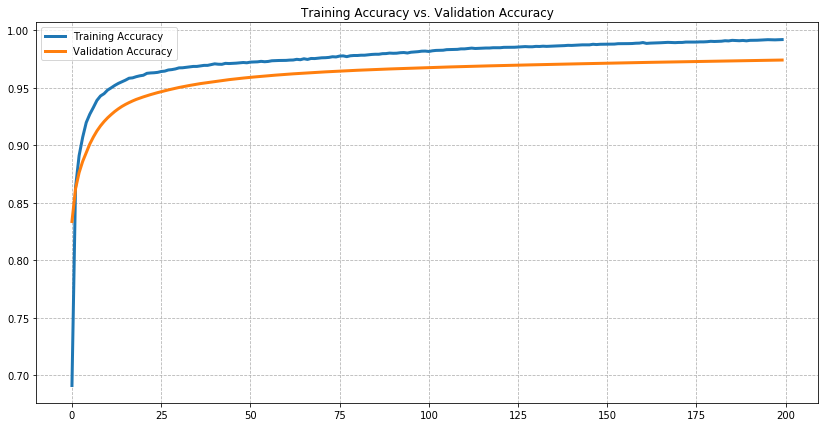

In [25]:
plt.figure(figsize=(14,7))
plt.plot(acc.accuracies, label = "Training Accuracy", linewidth = "3")
plt.plot(acc.test_accuracies, label = "Validation Accuracy", linewidth = "3")
plt.legend(loc='upper left')
plt.grid('both', alpha = 0.95, linestyle="--")
plt.title("Training Accuracy vs. Validation Accuracy");

Not too bad! 

Usually when the epochs progress, if the training accuracy and validation accuracy differ widely and move away from each other, then it is a sign of *overfitting*.

In our case, there is a small "moving away" happening. But since it is not so singificant, we are allowed to call it a good performance. 

The intuition behind validation accuracy and training accuracy is that if your model ends up learning *too* well, then it wouldn't be able to generalize for any new data it sees. This is ,in fact, what we call overfitting.

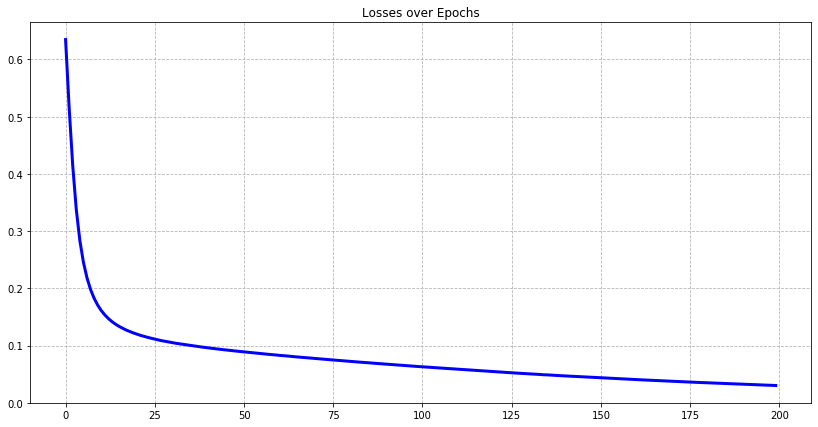

In [26]:
plt.figure(figsize=(14,7))
plt.plot(acc.losses, linewidth = "3", color = "b")
plt.grid('both', alpha = 0.95, linestyle="--")
plt.title("Losses over Epochs");

The graph above is the loss we see over the epochs. Clearly, the model is learning to approach the global minima through gradient descent. 

(although it is important to note that we may not have reached it completely) 

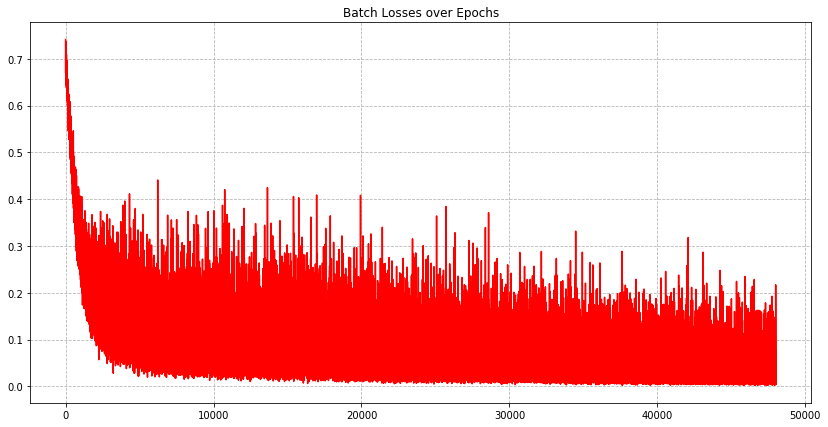

In [27]:
plt.figure(figsize=(14,7))
plt.plot(acc.batch_losses, color = "r")
plt.grid('both', alpha = 0.95, linestyle="--")
plt.title("Batch Losses over Epochs");

### 4. Plot the results

Our accuracy is 99.2%. Nice!

In order to see this more clearly, tn the embedding space ( the inputs of the "logistic regression") I am now plotting the data points by running them forward through the network. 

By coloring coding them with their actual class and plotting the probability contours (these will all be lines in the embedding space as from here on, this is a logistic regression), we can bettersee the points stranded on the "wrong" side of the probability 1/2 line. 

I have also plotted the predictions against the actual values showing where they are in the embedding space.

I have also tried doing a 3D plot to see the Sigma shape of the logistics working. (X - first output from the affine layer; Y- second output from the affine layer; Z - the probability of the X,Y data)

In [28]:
actual_inputs = np.concatenate((X_train, X_test))
actual_outputs = np.concatenate((y_train, y_test))
predicted_outputs =  1*(model(actual_inputs) >= 0.5)

In [29]:
np.mean(actual_outputs == predicted_outputs)

0.9910496921094085

In [30]:
#hide

#getting the last two layers for plotting
prob_layer = [Affine("output", 2, 1), Sigmoid("sigmoid")]
prob_model = Model(prob_layer)
prob_model.layers[0].params['w'] = model.layers[5].params['w']
prob_model.layers[0].params['b'] = model.layers[5].params['b']

In [31]:
#hide

#getting the layers upto the affine layer for plotting
visualize_layers = [Affine("first", 784, 100), Relu("relu"), Affine("second", 100, 100), Relu("relu"), Affine("third", 100, 2)]
visualize_model = Model(visualize_layers)

In [32]:
#hide
visualize_model.layers[0].params['w'] = model.layers[0].params['w']
visualize_model.layers[0].params['b'] = model.layers[0].params['b']
visualize_model.layers[2].params['w'] = model.layers[2].params['w']
visualize_model.layers[2].params['b'] = model.layers[0].params['b']
visualize_model.layers[4].params['w'] = model.layers[4].params['w']
visualize_model.layers[4].params['b'] = model.layers[4].params['b']

In [33]:
#hide
visualization_points_3 = visualize_model(data_3)
model_points_3 = model(data_3)

visualization_points_8 = visualize_model(data_8)
model_points_8 = model(data_8)

In [34]:
visualize_model_1 = Model(layers[:-2])
plot_testing = visualize_model_1(X_test)

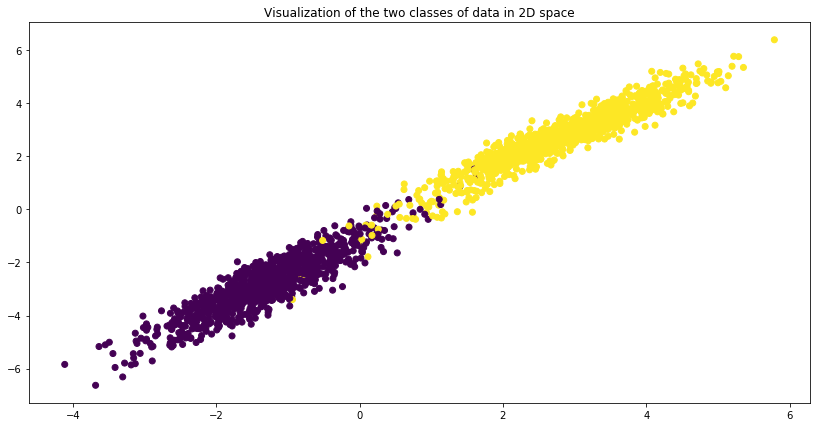

In [37]:
plt.figure(figsize=(14,7))
plt.scatter(plot_testing[:,0], plot_testing[:,1], c = y_test.ravel());
plt.title("Visualization of the two classes of data in 2D space");

In [38]:
#this would be our probability layer (last two layers)
model_prob = Model(layers[-2:])

In [39]:
xgrid = np.linspace(-4, 1, 100) 
ygrid = np.linspace(-7.5, 7.5, 100) 
xg, yg = np.meshgrid(xgrid, ygrid)
# xg and yg are now both 100X100 -> we need to conver them to single arrays 

xg_interim = np.ravel(xg)
yg_interim = np.ravel(yg)

# xg_interim, yg_interim are now arrays of len 10000, now we will stack them and then transpose to get desired shape of n rows, 2 columns

X_interim = np.vstack((xg_interim, yg_interim)) 
X = X_interim.T

# We want a shape of n rows and 2 columns in order to be able to feed this to last affine
# This last affine takes only two columns, hence the above transformation
probability_contour = model_prob(X).reshape(100,100) 

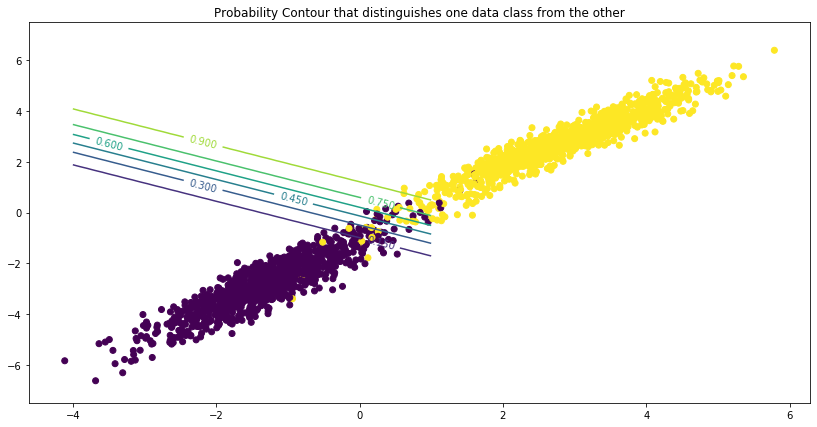

In [41]:
plt.figure(figsize=(14,7))
plt.scatter(plot_testing[:,0], plot_testing[:,1], c = y_test.ravel())
contours = plt.contour(xg,yg,probability_contour)
plt.clabel(contours, inline = True );
plt.title("Probability Contour that distinguishes one data class from the other");

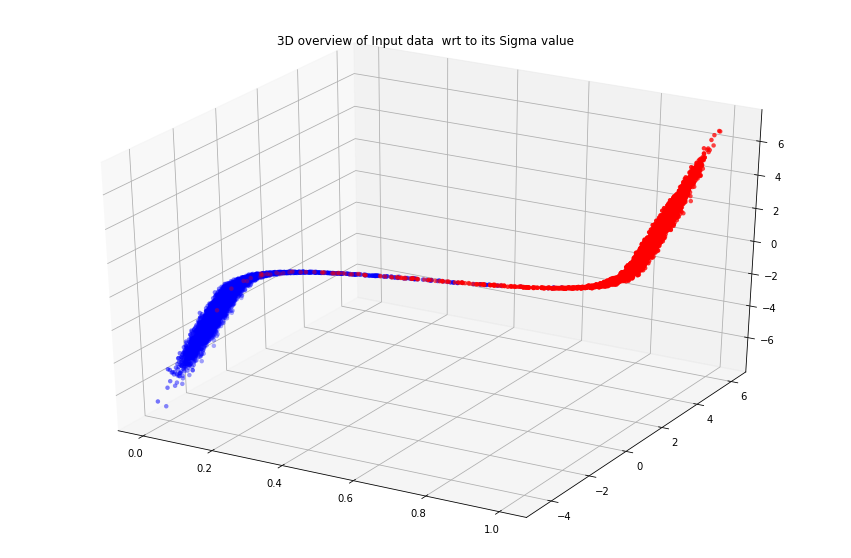

In [51]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import math
from matplotlib import cm

xx, yy = np.mgrid[-5:5:.01, -5:5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = prob_model(grid)


#contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)

fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection='3d')
ax.scatter(model_points_3, visualization_points_3.T[0], visualization_points_3.T[1],linewidth=0, c='r')
ax.scatter(model_points_8, visualization_points_8.T[0], visualization_points_8.T[1],linewidth=0, c='b')
plt.title("3D overview of Input data  wrt to its Sigma value");
#ax.plot_surface(xx, yy, z, alpha=0.2)
#ax.view_init(elev=90, azim=75)

Super cool! 

Let's now do a simpple Logistic Regression Model and compare it with the Neural Network we had constructed. 

It would be pretty interesting to see the difference in outcomes. 

In [60]:
model_logistic = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

learner2 = Learner(loss, model_logistic, opt, config.num_epochs)
acc2 = AccCallback(learner2, config.bs)
learner2.set_callbacks([acc2])
learner2.train_loop(train_dl,X_test, y_test)

Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1020.50it/s]


Epoch: 0     Loss: 0.58998     Training Acc: 0.76214     Validation Acc: 0.86442


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1007.41it/s]


Epoch: 1     Loss: 0.48206     Training Acc: 0.89059     Validation Acc: 0.88962


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 924.46it/s]


Epoch: 2     Loss: 0.41743     Training Acc: 0.91003     Validation Acc: 0.90155


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 940.08it/s]


Epoch: 3     Loss: 0.37494     Training Acc: 0.91604     Validation Acc: 0.90927


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 836.33it/s]


Epoch: 4     Loss: 0.34478     Training Acc: 0.91971     Validation Acc: 0.91431


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 944.86it/s]


Epoch: 5     Loss: 0.32209     Training Acc: 0.92238     Validation Acc: 0.91818


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 910.63it/s]


Epoch: 6     Loss: 0.30422     Training Acc: 0.92439     Validation Acc: 0.92137


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 898.35it/s]


Epoch: 7     Loss: 0.2897     Training Acc: 0.92772     Validation Acc: 0.92427


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1019.56it/s]


Epoch: 8     Loss: 0.27759     Training Acc: 0.92931     Validation Acc: 0.92664


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 951.50it/s]


Epoch: 9     Loss: 0.26732     Training Acc: 0.9309     Validation Acc: 0.92858


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1023.41it/s]


Epoch: 10     Loss: 0.25842     Training Acc: 0.93215     Validation Acc: 0.93017


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 967.74it/s]


Epoch: 11     Loss: 0.25064     Training Acc: 0.93323     Validation Acc: 0.93162


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1155.08it/s]


Epoch: 12     Loss: 0.24374     Training Acc: 0.9344     Validation Acc: 0.93289


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1044.76it/s]


Epoch: 13     Loss: 0.23758     Training Acc: 0.93515     Validation Acc: 0.93404


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1180.46it/s]


Epoch: 14     Loss: 0.23203     Training Acc: 0.93582     Validation Acc: 0.93508


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 932.71it/s]


Epoch: 15     Loss: 0.227     Training Acc: 0.93707     Validation Acc: 0.93596


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 862.44it/s]


Epoch: 16     Loss: 0.2224     Training Acc: 0.93766     Validation Acc: 0.93676


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1056.66it/s]


Epoch: 17     Loss: 0.2182     Training Acc: 0.93891     Validation Acc: 0.93753


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1081.94it/s]


Epoch: 18     Loss: 0.21431     Training Acc: 0.93941     Validation Acc: 0.93824


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1064.15it/s]


Epoch: 19     Loss: 0.21073     Training Acc: 0.94041     Validation Acc: 0.93896


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 730.74it/s]


Epoch: 20     Loss: 0.20741     Training Acc: 0.94091     Validation Acc: 0.93961


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 759.57it/s]


Epoch: 21     Loss: 0.2043     Training Acc: 0.942     Validation Acc: 0.94023


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 735.06it/s]


Epoch: 22     Loss: 0.20139     Training Acc: 0.94233     Validation Acc: 0.94077


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 766.24it/s]


Epoch: 23     Loss: 0.19869     Training Acc: 0.94258     Validation Acc: 0.94128


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 731.28it/s]


Epoch: 24     Loss: 0.19614     Training Acc: 0.943     Validation Acc: 0.94179


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 732.20it/s]


Epoch: 25     Loss: 0.19374     Training Acc: 0.94375     Validation Acc: 0.94231


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 733.73it/s]


Epoch: 26     Loss: 0.19147     Training Acc: 0.94417     Validation Acc: 0.94282


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 867.13it/s]


Epoch: 27     Loss: 0.18934     Training Acc: 0.94467     Validation Acc: 0.9433


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 969.42it/s]


Epoch: 28     Loss: 0.18731     Training Acc: 0.94525     Validation Acc: 0.94376


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 971.19it/s]


Epoch: 29     Loss: 0.18538     Training Acc: 0.94517     Validation Acc: 0.94419


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 974.84it/s]


Epoch: 30     Loss: 0.18356     Training Acc: 0.9455     Validation Acc: 0.94457


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 984.84it/s]


Epoch: 31     Loss: 0.18182     Training Acc: 0.94592     Validation Acc: 0.94495


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1003.09it/s]


Epoch: 32     Loss: 0.18016     Training Acc: 0.94609     Validation Acc: 0.9453


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 963.23it/s]


Epoch: 33     Loss: 0.17858     Training Acc: 0.94625     Validation Acc: 0.94564


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 939.20it/s]


Epoch: 34     Loss: 0.17707     Training Acc: 0.94675     Validation Acc: 0.94595


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 953.51it/s]


Epoch: 35     Loss: 0.17562     Training Acc: 0.94734     Validation Acc: 0.94626


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1030.64it/s]


Epoch: 36     Loss: 0.17423     Training Acc: 0.94792     Validation Acc: 0.94657


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1039.51it/s]


Epoch: 37     Loss: 0.1729     Training Acc: 0.94834     Validation Acc: 0.94688


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1010.24it/s]


Epoch: 38     Loss: 0.17163     Training Acc: 0.94892     Validation Acc: 0.94718


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 953.90it/s]


Epoch: 39     Loss: 0.1704     Training Acc: 0.94951     Validation Acc: 0.94747


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 969.25it/s]


Epoch: 40     Loss: 0.16922     Training Acc: 0.94976     Validation Acc: 0.94775


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 983.74it/s]


Epoch: 41     Loss: 0.16808     Training Acc: 0.95026     Validation Acc: 0.94802


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1062.71it/s]


Epoch: 42     Loss: 0.16698     Training Acc: 0.95043     Validation Acc: 0.9483


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1028.78it/s]


Epoch: 43     Loss: 0.16593     Training Acc: 0.95109     Validation Acc: 0.94857


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1007.49it/s]


Epoch: 44     Loss: 0.16492     Training Acc: 0.95151     Validation Acc: 0.94882


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1111.62it/s]


Epoch: 45     Loss: 0.16393     Training Acc: 0.95143     Validation Acc: 0.94907


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1103.27it/s]


Epoch: 46     Loss: 0.16298     Training Acc: 0.95184     Validation Acc: 0.94931


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1075.76it/s]


Epoch: 47     Loss: 0.16206     Training Acc: 0.95184     Validation Acc: 0.94953


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 960.58it/s]


Epoch: 48     Loss: 0.16117     Training Acc: 0.95193     Validation Acc: 0.94976


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1011.45it/s]


Epoch: 49     Loss: 0.16031     Training Acc: 0.95226     Validation Acc: 0.94997


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1143.73it/s]


Epoch: 50     Loss: 0.15948     Training Acc: 0.95201     Validation Acc: 0.95018


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1043.87it/s]


Epoch: 51     Loss: 0.15867     Training Acc: 0.95226     Validation Acc: 0.95038


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 929.92it/s]


Epoch: 52     Loss: 0.15789     Training Acc: 0.95243     Validation Acc: 0.95059


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1017.34it/s]


Epoch: 53     Loss: 0.15712     Training Acc: 0.95218     Validation Acc: 0.95078


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1132.85it/s]


Epoch: 54     Loss: 0.15638     Training Acc: 0.95235     Validation Acc: 0.95098


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 986.97it/s]


Epoch: 55     Loss: 0.15566     Training Acc: 0.95226     Validation Acc: 0.95117


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1159.23it/s]


Epoch: 56     Loss: 0.15496     Training Acc: 0.95243     Validation Acc: 0.95136


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 969.62it/s]


Epoch: 57     Loss: 0.15428     Training Acc: 0.95293     Validation Acc: 0.95153


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1074.38it/s]


Epoch: 58     Loss: 0.15362     Training Acc: 0.95268     Validation Acc: 0.95172


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1044.32it/s]


Epoch: 59     Loss: 0.15297     Training Acc: 0.95301     Validation Acc: 0.9519


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1107.44it/s]


Epoch: 60     Loss: 0.15234     Training Acc: 0.95293     Validation Acc: 0.95208


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1092.28it/s]


Epoch: 61     Loss: 0.15173     Training Acc: 0.95326     Validation Acc: 0.95225


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1027.35it/s]


Epoch: 62     Loss: 0.15114     Training Acc: 0.95335     Validation Acc: 0.95241


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1030.94it/s]


Epoch: 63     Loss: 0.15055     Training Acc: 0.95401     Validation Acc: 0.95257


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1017.01it/s]


Epoch: 64     Loss: 0.14999     Training Acc: 0.95393     Validation Acc: 0.95274


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1148.74it/s]


Epoch: 65     Loss: 0.14943     Training Acc: 0.95426     Validation Acc: 0.9529


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 934.44it/s]


Epoch: 66     Loss: 0.14889     Training Acc: 0.95452     Validation Acc: 0.95306


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1053.70it/s]


Epoch: 67     Loss: 0.14836     Training Acc: 0.9546     Validation Acc: 0.95323


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1093.25it/s]


Epoch: 68     Loss: 0.14785     Training Acc: 0.95477     Validation Acc: 0.95339


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1086.24it/s]


Epoch: 69     Loss: 0.14734     Training Acc: 0.95468     Validation Acc: 0.95354


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 925.62it/s]


Epoch: 70     Loss: 0.14685     Training Acc: 0.95468     Validation Acc: 0.95368


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 953.79it/s]


Epoch: 71     Loss: 0.14637     Training Acc: 0.95535     Validation Acc: 0.95382


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1020.56it/s]


Epoch: 72     Loss: 0.14589     Training Acc: 0.9551     Validation Acc: 0.95395


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1081.29it/s]


Epoch: 73     Loss: 0.14544     Training Acc: 0.9556     Validation Acc: 0.95409


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 964.74it/s]


Epoch: 74     Loss: 0.14498     Training Acc: 0.95543     Validation Acc: 0.95422


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 932.19it/s]


Epoch: 75     Loss: 0.14454     Training Acc: 0.95552     Validation Acc: 0.95436


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1130.48it/s]


Epoch: 76     Loss: 0.1441     Training Acc: 0.95577     Validation Acc: 0.95449


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1008.82it/s]


Epoch: 77     Loss: 0.14368     Training Acc: 0.95593     Validation Acc: 0.95462


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 981.91it/s]


Epoch: 78     Loss: 0.14326     Training Acc: 0.95618     Validation Acc: 0.95476


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 976.34it/s]


Epoch: 79     Loss: 0.14285     Training Acc: 0.95627     Validation Acc: 0.95489


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1016.59it/s]


Epoch: 80     Loss: 0.14246     Training Acc: 0.95627     Validation Acc: 0.95502


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1060.88it/s]


Epoch: 81     Loss: 0.14207     Training Acc: 0.95643     Validation Acc: 0.95514


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 991.35it/s]


Epoch: 82     Loss: 0.14168     Training Acc: 0.95652     Validation Acc: 0.95526


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 928.89it/s]


Epoch: 83     Loss: 0.1413     Training Acc: 0.95643     Validation Acc: 0.95538


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1079.90it/s]


Epoch: 84     Loss: 0.14093     Training Acc: 0.95669     Validation Acc: 0.9555


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1050.91it/s]


Epoch: 85     Loss: 0.14057     Training Acc: 0.95685     Validation Acc: 0.95562


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1026.73it/s]


Epoch: 86     Loss: 0.14021     Training Acc: 0.95685     Validation Acc: 0.95574


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 974.40it/s]


Epoch: 87     Loss: 0.13986     Training Acc: 0.95719     Validation Acc: 0.95585


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1134.25it/s]


Epoch: 88     Loss: 0.13951     Training Acc: 0.95719     Validation Acc: 0.95596


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1053.70it/s]


Epoch: 89     Loss: 0.13917     Training Acc: 0.95727     Validation Acc: 0.95607


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 969.70it/s]


Epoch: 90     Loss: 0.13884     Training Acc: 0.95719     Validation Acc: 0.95618


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 989.44it/s]


Epoch: 91     Loss: 0.13852     Training Acc: 0.9576     Validation Acc: 0.95629


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1012.84it/s]


Epoch: 92     Loss: 0.1382     Training Acc: 0.95752     Validation Acc: 0.9564


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1024.60it/s]


Epoch: 93     Loss: 0.13788     Training Acc: 0.95785     Validation Acc: 0.95651


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1001.09it/s]


Epoch: 94     Loss: 0.13757     Training Acc: 0.95744     Validation Acc: 0.95663


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1045.79it/s]


Epoch: 95     Loss: 0.13726     Training Acc: 0.95827     Validation Acc: 0.95674


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 999.15it/s]


Epoch: 96     Loss: 0.13697     Training Acc: 0.95785     Validation Acc: 0.95685


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1139.13it/s]


Epoch: 97     Loss: 0.13667     Training Acc: 0.95835     Validation Acc: 0.95694


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1088.97it/s]


Epoch: 98     Loss: 0.13638     Training Acc: 0.95827     Validation Acc: 0.95704


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1075.16it/s]


Epoch: 99     Loss: 0.13609     Training Acc: 0.95827     Validation Acc: 0.95714


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1081.06it/s]


Epoch: 100     Loss: 0.13581     Training Acc: 0.95827     Validation Acc: 0.95723


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 965.27it/s]


Epoch: 101     Loss: 0.13553     Training Acc: 0.95852     Validation Acc: 0.95732


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1148.67it/s]


Epoch: 102     Loss: 0.13526     Training Acc: 0.95835     Validation Acc: 0.95741


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 955.62it/s]


Epoch: 103     Loss: 0.13499     Training Acc: 0.95844     Validation Acc: 0.95749


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1019.76it/s]


Epoch: 104     Loss: 0.13473     Training Acc: 0.95827     Validation Acc: 0.95758


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 993.87it/s]


Epoch: 105     Loss: 0.13447     Training Acc: 0.9586     Validation Acc: 0.95767


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 921.80it/s]


Epoch: 106     Loss: 0.13421     Training Acc: 0.95852     Validation Acc: 0.95775


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1065.24it/s]


Epoch: 107     Loss: 0.13395     Training Acc: 0.95844     Validation Acc: 0.95783


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1048.84it/s]


Epoch: 108     Loss: 0.13371     Training Acc: 0.95844     Validation Acc: 0.95791


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 976.38it/s]


Epoch: 109     Loss: 0.13346     Training Acc: 0.95827     Validation Acc: 0.95798


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1057.47it/s]


Epoch: 110     Loss: 0.13321     Training Acc: 0.95835     Validation Acc: 0.95806


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 939.88it/s]


Epoch: 111     Loss: 0.13298     Training Acc: 0.95844     Validation Acc: 0.95813


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1043.91it/s]


Epoch: 112     Loss: 0.13274     Training Acc: 0.9586     Validation Acc: 0.9582


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1140.88it/s]


Epoch: 113     Loss: 0.1325     Training Acc: 0.95877     Validation Acc: 0.95827


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 946.59it/s]


Epoch: 114     Loss: 0.13228     Training Acc: 0.95869     Validation Acc: 0.95834


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1047.17it/s]


Epoch: 115     Loss: 0.13205     Training Acc: 0.95869     Validation Acc: 0.95841


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1058.17it/s]


Epoch: 116     Loss: 0.13183     Training Acc: 0.95885     Validation Acc: 0.95848


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1056.58it/s]


Epoch: 117     Loss: 0.13161     Training Acc: 0.95877     Validation Acc: 0.95854


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 926.83it/s]


Epoch: 118     Loss: 0.13139     Training Acc: 0.95852     Validation Acc: 0.95861


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 979.86it/s]


Epoch: 119     Loss: 0.13117     Training Acc: 0.95885     Validation Acc: 0.95867


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1066.77it/s]


Epoch: 120     Loss: 0.13096     Training Acc: 0.95852     Validation Acc: 0.95873


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1145.77it/s]


Epoch: 121     Loss: 0.13075     Training Acc: 0.95877     Validation Acc: 0.95879


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1002.97it/s]


Epoch: 122     Loss: 0.13055     Training Acc: 0.95885     Validation Acc: 0.95885


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 969.43it/s]


Epoch: 123     Loss: 0.13034     Training Acc: 0.95894     Validation Acc: 0.95891


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1043.44it/s]


Epoch: 124     Loss: 0.13014     Training Acc: 0.95877     Validation Acc: 0.95897


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1051.78it/s]


Epoch: 125     Loss: 0.12994     Training Acc: 0.95885     Validation Acc: 0.95903


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1083.99it/s]


Epoch: 126     Loss: 0.12974     Training Acc: 0.95902     Validation Acc: 0.95909


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 997.46it/s]


Epoch: 127     Loss: 0.12955     Training Acc: 0.95911     Validation Acc: 0.95914


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1085.59it/s]


Epoch: 128     Loss: 0.12936     Training Acc: 0.95911     Validation Acc: 0.9592


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 993.75it/s]


Epoch: 129     Loss: 0.12917     Training Acc: 0.95936     Validation Acc: 0.95925


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1003.96it/s]


Epoch: 130     Loss: 0.12898     Training Acc: 0.95919     Validation Acc: 0.9593


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 976.61it/s]


Epoch: 131     Loss: 0.1288     Training Acc: 0.95952     Validation Acc: 0.95936


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1122.26it/s]


Epoch: 132     Loss: 0.1286     Training Acc: 0.95927     Validation Acc: 0.95941


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1124.30it/s]


Epoch: 133     Loss: 0.12844     Training Acc: 0.95977     Validation Acc: 0.95946


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1163.73it/s]


Epoch: 134     Loss: 0.12826     Training Acc: 0.95977     Validation Acc: 0.95951


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1108.03it/s]


Epoch: 135     Loss: 0.12808     Training Acc: 0.95977     Validation Acc: 0.95956


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 994.29it/s]


Epoch: 136     Loss: 0.12791     Training Acc: 0.95986     Validation Acc: 0.95961


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 946.09it/s]


Epoch: 137     Loss: 0.12773     Training Acc: 0.95994     Validation Acc: 0.95966


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 881.36it/s]


Epoch: 138     Loss: 0.12756     Training Acc: 0.95986     Validation Acc: 0.95971


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1099.90it/s]


Epoch: 139     Loss: 0.1274     Training Acc: 0.95986     Validation Acc: 0.95975


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 925.18it/s]


Epoch: 140     Loss: 0.12723     Training Acc: 0.95994     Validation Acc: 0.9598


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 857.33it/s]


Epoch: 141     Loss: 0.12706     Training Acc: 0.95994     Validation Acc: 0.95984


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 982.14it/s]


Epoch: 142     Loss: 0.1269     Training Acc: 0.95994     Validation Acc: 0.95988


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1029.41it/s]


Epoch: 143     Loss: 0.12674     Training Acc: 0.96002     Validation Acc: 0.95992


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 940.95it/s]


Epoch: 144     Loss: 0.12658     Training Acc: 0.96011     Validation Acc: 0.95996


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 909.22it/s]


Epoch: 145     Loss: 0.12642     Training Acc: 0.96011     Validation Acc: 0.96


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 980.76it/s]


Epoch: 146     Loss: 0.12626     Training Acc: 0.96019     Validation Acc: 0.96004


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1067.81it/s]


Epoch: 147     Loss: 0.12611     Training Acc: 0.96019     Validation Acc: 0.96008


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 878.44it/s]


Epoch: 148     Loss: 0.12596     Training Acc: 0.96011     Validation Acc: 0.96012


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 967.75it/s]


Epoch: 149     Loss: 0.12581     Training Acc: 0.95994     Validation Acc: 0.96016


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 950.50it/s]


Epoch: 150     Loss: 0.12565     Training Acc: 0.96002     Validation Acc: 0.9602


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 967.73it/s]


Epoch: 151     Loss: 0.12551     Training Acc: 0.96036     Validation Acc: 0.96024


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 872.72it/s]


Epoch: 152     Loss: 0.12536     Training Acc: 0.96027     Validation Acc: 0.96029


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 975.61it/s]


Epoch: 153     Loss: 0.12522     Training Acc: 0.96052     Validation Acc: 0.96033


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 828.82it/s]


Epoch: 154     Loss: 0.12507     Training Acc: 0.96044     Validation Acc: 0.96037


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 874.87it/s]


Epoch: 155     Loss: 0.12493     Training Acc: 0.96052     Validation Acc: 0.96041


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 869.82it/s]


Epoch: 156     Loss: 0.12479     Training Acc: 0.96036     Validation Acc: 0.96045


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 975.57it/s]


Epoch: 157     Loss: 0.12465     Training Acc: 0.96069     Validation Acc: 0.96049


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 994.08it/s]


Epoch: 158     Loss: 0.12451     Training Acc: 0.96086     Validation Acc: 0.96053


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 998.34it/s]


Epoch: 159     Loss: 0.12438     Training Acc: 0.96061     Validation Acc: 0.96058


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 966.37it/s]


Epoch: 160     Loss: 0.12424     Training Acc: 0.96069     Validation Acc: 0.96062


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 966.70it/s]


Epoch: 161     Loss: 0.1241     Training Acc: 0.96094     Validation Acc: 0.96066


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 827.83it/s]


Epoch: 162     Loss: 0.12397     Training Acc: 0.96069     Validation Acc: 0.9607


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 797.34it/s]


Epoch: 163     Loss: 0.12384     Training Acc: 0.96086     Validation Acc: 0.96075


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 888.88it/s]


Epoch: 164     Loss: 0.12371     Training Acc: 0.96077     Validation Acc: 0.96079


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 793.34it/s]


Epoch: 165     Loss: 0.12358     Training Acc: 0.96086     Validation Acc: 0.96083


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 993.16it/s]


Epoch: 166     Loss: 0.12345     Training Acc: 0.96094     Validation Acc: 0.96087


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 936.12it/s]


Epoch: 167     Loss: 0.12332     Training Acc: 0.96094     Validation Acc: 0.96091


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 968.33it/s]


Epoch: 168     Loss: 0.1232     Training Acc: 0.96102     Validation Acc: 0.96095


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 869.30it/s]


Epoch: 169     Loss: 0.12308     Training Acc: 0.96111     Validation Acc: 0.96099


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1048.13it/s]


Epoch: 170     Loss: 0.12295     Training Acc: 0.96111     Validation Acc: 0.96103


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 893.73it/s]


Epoch: 171     Loss: 0.12283     Training Acc: 0.96111     Validation Acc: 0.96107


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 970.86it/s]


Epoch: 172     Loss: 0.12271     Training Acc: 0.96111     Validation Acc: 0.96111


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 978.44it/s]


Epoch: 173     Loss: 0.12259     Training Acc: 0.96111     Validation Acc: 0.96115


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1045.09it/s]


Epoch: 174     Loss: 0.12247     Training Acc: 0.96128     Validation Acc: 0.96119


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1015.32it/s]


Epoch: 175     Loss: 0.12235     Training Acc: 0.96144     Validation Acc: 0.96122


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 946.11it/s]


Epoch: 176     Loss: 0.12223     Training Acc: 0.96128     Validation Acc: 0.96126


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1076.88it/s]


Epoch: 177     Loss: 0.12212     Training Acc: 0.96128     Validation Acc: 0.96129


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1028.94it/s]


Epoch: 178     Loss: 0.122     Training Acc: 0.96136     Validation Acc: 0.96132


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 971.06it/s]


Epoch: 179     Loss: 0.12189     Training Acc: 0.96161     Validation Acc: 0.96135


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 889.96it/s]


Epoch: 180     Loss: 0.12177     Training Acc: 0.96144     Validation Acc: 0.96139


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1043.94it/s]


Epoch: 181     Loss: 0.12166     Training Acc: 0.96169     Validation Acc: 0.96142


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 969.80it/s]


Epoch: 182     Loss: 0.12155     Training Acc: 0.96144     Validation Acc: 0.96145


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1126.50it/s]


Epoch: 183     Loss: 0.12144     Training Acc: 0.96153     Validation Acc: 0.96148


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1040.79it/s]


Epoch: 184     Loss: 0.12133     Training Acc: 0.96178     Validation Acc: 0.96151


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 927.91it/s]


Epoch: 185     Loss: 0.12122     Training Acc: 0.96169     Validation Acc: 0.96153


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 993.69it/s]


Epoch: 186     Loss: 0.12112     Training Acc: 0.96186     Validation Acc: 0.96156


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1054.61it/s]


Epoch: 187     Loss: 0.12101     Training Acc: 0.96194     Validation Acc: 0.96159


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 899.15it/s]


Epoch: 188     Loss: 0.12091     Training Acc: 0.96186     Validation Acc: 0.96162


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 941.20it/s]


Epoch: 189     Loss: 0.1208     Training Acc: 0.96211     Validation Acc: 0.96164


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1068.21it/s]


Epoch: 190     Loss: 0.12069     Training Acc: 0.96203     Validation Acc: 0.96167


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1151.84it/s]


Epoch: 191     Loss: 0.12059     Training Acc: 0.96211     Validation Acc: 0.9617


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1154.45it/s]


Epoch: 192     Loss: 0.12049     Training Acc: 0.96219     Validation Acc: 0.96172


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 954.49it/s]


Epoch: 193     Loss: 0.12039     Training Acc: 0.96228     Validation Acc: 0.96175


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1038.07it/s]


Epoch: 194     Loss: 0.12029     Training Acc: 0.96228     Validation Acc: 0.96177


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 992.65it/s]


Epoch: 195     Loss: 0.12018     Training Acc: 0.96244     Validation Acc: 0.9618


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 980.77it/s]


Epoch: 196     Loss: 0.12008     Training Acc: 0.96186     Validation Acc: 0.96182


Batch: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 1027.28it/s]


Epoch: 197     Loss: 0.11999     Training Acc: 0.96228     Validation Acc: 0.96185


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 946.58it/s]


Epoch: 198     Loss: 0.11989     Training Acc: 0.96228     Validation Acc: 0.96187


Batch: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 960.29it/s]


Epoch: 199     Loss: 0.11979     Training Acc: 0.96236     Validation Acc: 0.9619


0.023917621718399874

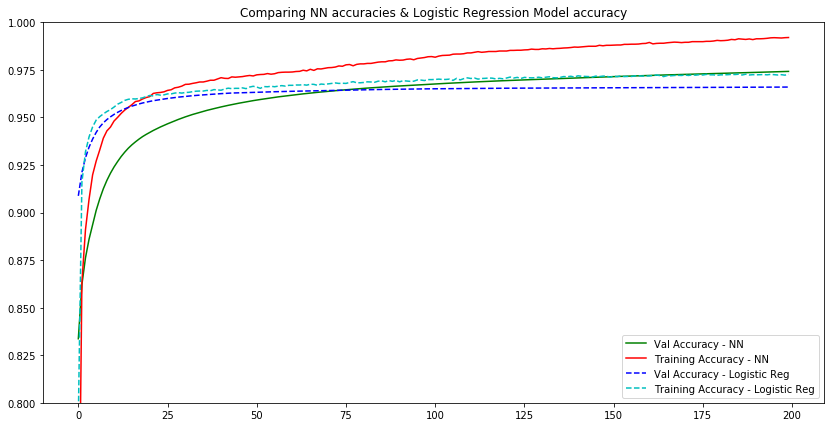

In [59]:
plt.figure(figsize=(14,7))
plt.plot(acc.test_accuracies, 'g-', label = "Val Accuracy - NN")
plt.plot(acc.accuracies, 'r-', label = "Training Accuracy - NN")
plt.plot(acc2.test_accuracies, 'b-',linestyle="--", label = "Val Accuracy - Logistic Reg")
plt.plot(acc2.accuracies, 'c-',linestyle="--", label = "Training Accuracy - Logistic Reg")
plt.ylim(0.8,1) ## for a more spread out view
plt.legend()
plt.title("Comparing NN accuracies & Logistic Regression Model accuracy");

...And the winner is our lovely Neural Network model!

Looking at this graph, clearly the Neural network performed better than our simple logistics model. 